# TP2

**Objetivo:** Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: "focus_video.mov".

Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain" y realizar tres experimentos:

1. Medición sobre todo el frame.
2. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 50 10% del area total del frame.
Para cada experimento se debe presentar:

Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.
El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

**Puntos extra:** Aplicar unsharp masking para expandir la zona de enfoque y devolver.

Ejemplo:

![image](https://github.com/user-attachments/assets/7b447ea7-95d5-4afb-b770-dc40a2f2a448)


## Experimentos

### 1. Extracción de frames del video


In [1]:
import subprocess
import os

video_path = 'focus_video.mov'
output_dir = 'extracted_frames'  # Directorio para almacenar los frames
os.makedirs(output_dir, exist_ok=True)  # Crear directorio si no existe

# Extraer cada 1 frame por segundo usando FFmpeg
# %04d crea nombres de archivos de 4 dígitos secuenciales (e.g., frame_0001.png)
extract_command = f'ffmpeg -i {video_path} -vf fps=30 {output_dir}/frame_%04d.png'
subprocess.run(extract_command, shell=True)


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with clang version 18.1.8
  configuration: --prefix=/opt/anaconda3/envs/ia_ceia_18co --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1741820504521/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --disable-gnutls --enable-libmp3lame --enable-libvpx --enable-libass --enable-pthreads --enable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zlib --enable

CompletedProcess(args='ffmpeg -i focus_video.mov -vf fps=30 extracted_frames/frame_%04d.png', returncode=0)

### 2. Implementación de la métrica de enfoque

In [2]:
import cv2
import numpy as np

def calculate_sharpness(input_image, unsharp_masking = 0):
    """
    Calcula la métrica de nitidez de la imagen basándose en componentes de alta frecuencia en el dominio de Fourier (algoritmo del artículo referenciado).
    Argumentos:
    input_image(numpy.ndarray): Imagen a color en formato RGB.

    Devuelve:
    float: Puntuación de nitidez entre 0 (borrosa) y 1 (nítida). / sharpness_score
    """
    if(unsharp_masking > 0):
        input_image = aplicar_unsharp_masking(input_image, unsharp_masking)

    # Convertir a escala de grises para el análisis de frecuencias
    grayscale_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    
    # Fast Fourier Transform (FFT) and shift zero-frequency to center
    fourier_transform = np.fft.fft2(grayscale_image)
    fourier_shifted = np.fft.fftshift(fourier_transform)
    
    # Get magnitude spectrum (absolute values)
    magnitude_spectrum = np.abs(fourier_shifted)
    
    # Cálculo del umbral dinámico (1/1000 de la magnitud máxima)
    max_magnitude = np.max(magnitude_spectrum)
    high_freq_threshold = max_magnitude / 1000
    
    # Contar componentes de alta frecuencia por encima del umbral
    high_freq_mask = magnitude_spectrum > high_freq_threshold
    high_freq_count = np.sum(high_freq_mask)
    
    # Normalizar por el total de píxeles para obtener la puntuación de nitidez
    total_pixels = grayscale_image.shape[0] * grayscale_image.shape[1]
    sharpness_score = high_freq_count / total_pixels
    
    return sharpness_score


### 3. Experiment Configuration


In [3]:
def process_full_frame(frames_directory, unsharp_masking = 0):
    """
    Experimento 1: Análisis de nitidez en fotogramas completos de vídeo /Sharpness analysis on full video frames
    Argumentos:
        frames_directory (str): Ruta a los fotogramas extraídos

    Devuelve:
        list: Puntuaciones de nitidez de cada fotograma /Sharpness scores for each frame
    """
    frame_scores = []
    
    for frame_filename in sorted(os.listdir(frames_directory)):
        frame_path = os.path.join(frames_directory, frame_filename)
        frame_data = cv2.imread(frame_path)
        
        current_score = calculate_sharpness(frame_data, unsharp_masking)
        frame_scores.append(current_score)
    
    return frame_scores


def process_central_roi(frames_directory, unsharp_masking = 0):
    """
    Experimento 2: Análisis de nitidez en la región de interés (ROI) central
    Tamaño de la ROI = 10 % del área total del fotograma (cuadrado centrado en el fotograma)
    Argumentos:
        frames_directory (str): Ruta a los fotogramas extraídos

    Devuelve:
        list: Puntuaciones de nitidez para la ROI de cada fotograma/Sharpness scores for the ROI of each frame
    """
    roi_scores = []
    
    for frame_filename in sorted(os.listdir(frames_directory)):
        frame_path = os.path.join(frames_directory, frame_filename)
        frame_data = cv2.imread(frame_path)
        
        # calcular dimensiones de la ROI
        frame_height, frame_width = frame_data.shape[:2]
        frame_area = frame_width * frame_height
        roi_side = int(np.sqrt(0.1 * frame_area))  # raiz cuadrada de 10% del area total del frame
        
        # Coordenadas del centro
        center_x = frame_width // 2
        center_y = frame_height // 2
        
        # Extraer ROI (asegurando que esté dentro de los límites del fotograma)
        roi = frame_data[
            max(0, center_y - roi_side):min(frame_height, center_y + roi_side),
            max(0, center_x - roi_side):min(frame_width, center_x + roi_side)
        ]
        
        current_score = calculate_sharpness(roi, unsharp_masking)
        roi_scores.append(current_score)
    
    return roi_scores

### 4. Peak Detection Algorithm


In [4]:
def detect_sharpness_peaks(sharpness_scores, min_prominence=0.1):
    """
    Identifica los fotogramas con la máxima nitidez usando detección de picos
    
    Args:
        sharpness_scores (list): Sequence of sharpness values
        min_prominence (float): Minimum peak prominence (sensitivity control)
        
    Returns:
        np.ndarray: Indices of detected peak frames
    """
    peak_indices, _ = find_peaks(sharpness_scores, prominence=min_prominence)
    return peak_indices

### 5. Results Visualization


In [5]:
import matplotlib.pyplot as plt

def plot_sharpness_analysis(full_frame_scores, roi_scores, peak_frames_full, peak_frames_roi):
    """
    Visualiza las tendencias de nitidez y los puntos de enfoque detectados
    
    Args:
        full_frame_scores (list): Experiment 1 results
        roi_scores (list): Experiment 2 results
        peak_frames_full (np.ndarray): Full frame peak indices
        peak_frames_roi (np.ndarray): ROI peak indices
    """
    plt.figure(figsize=(14, 7))
    
    # Plot both datasets
    plt.plot(full_frame_scores, label='Full Frame Analysis', color='blue', alpha=0.7)
    plt.plot(roi_scores, label='Central ROI Analysis', color='green', alpha=0.7)
    
    # Mark detected peaks
    plt.scatter(peak_frames_full, [full_frame_scores[i] for i in peak_frames_full],
                color='red', marker='X', s=100, label='Full Frame Peaks')
    plt.scatter(peak_frames_roi, [roi_scores[i] for i in peak_frames_roi],
                color='purple', marker='D', s=80, label='ROI Peaks')
    
 # Formatting
    plt.title('Video Focus Analysis Comparison\n(Frame-by-Frame Sharpness Measurement)', pad=20)
    plt.xlabel('Frame Number', labelpad=15)
    plt.ylabel('Sharpness Score', labelpad=15)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### 6. Execution Pipeline

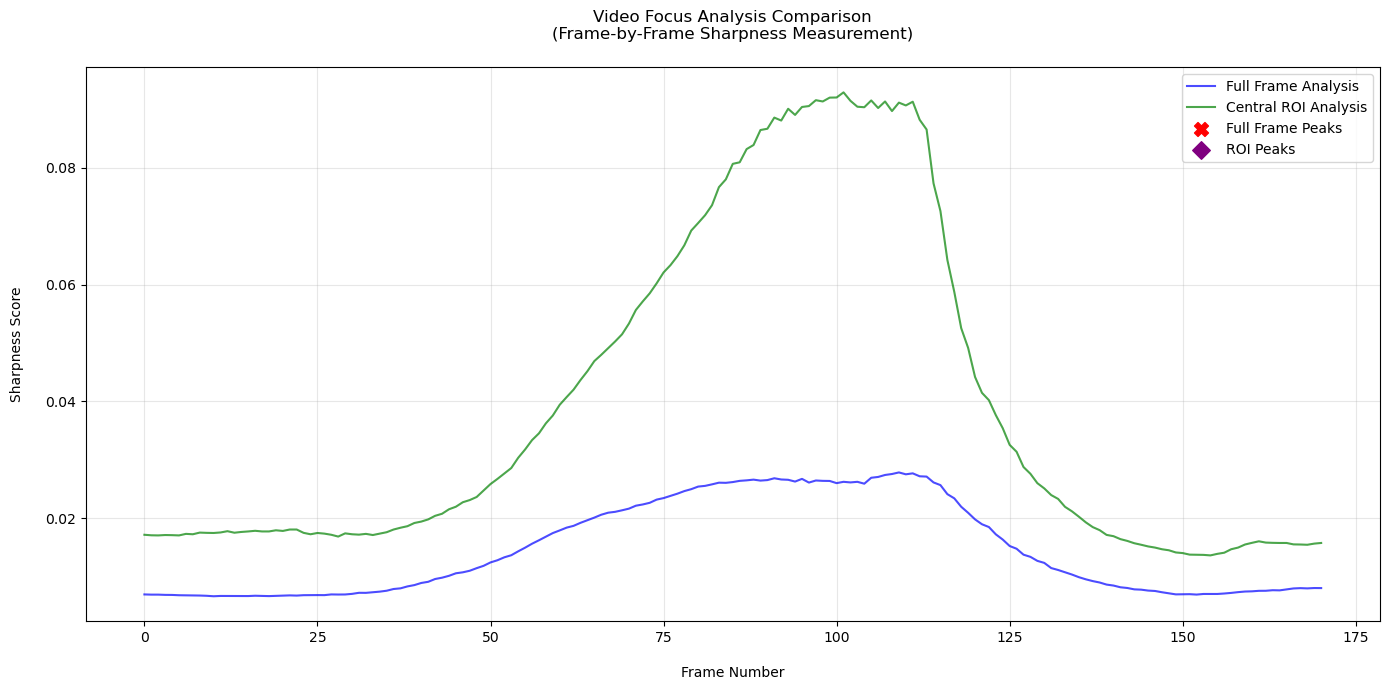

In [6]:
from scipy.signal import find_peaks

if __name__ == "__main__":
    # Process video frames
    full_scores = process_full_frame(output_dir, unsharp_masking = 0)
    roi_scores = process_central_roi(output_dir, unsharp_masking = 0)
    
    # Detect focus points
    full_peaks = detect_sharpness_peaks(full_scores)
    roi_peaks = detect_sharpness_peaks(roi_scores)
    
    # Generate visualization
    plot_sharpness_analysis(full_scores, roi_scores, full_peaks, roi_peaks)

## Punto extra  FALTA TERMINAR

### Unsharp masking

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def aplicar_unsharp_masking(imagen_original, k=1):
    """
    Aplica técnica unsharp masking para expandir la zona de enfoque.
    Parámetros:
    - imagen_original (numpy.ndarray): Imagen de entrada en formato BGR
    - fuerza (float): Intensidad del efecto de enfoque (1.0 = efecto neutro)
    
    Retorna:
    - img_sharp: Imagen mejorada con zona de enfoque expandida
    """

    # La convertimos a RGB
    imagen_original = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2RGB)
    # Suavizar la imagen
    gauss = cv2.GaussianBlur(imagen_original, (7,7), 0.5)
    # Aplicar la máscara de enfoque: 
    # addWeighted calcula la suma pesada de dos arreglos según: dst(I)=saturate(src1(I)∗alpha+src2(I)∗beta+gamma)
    # parámetros: (src1(I),alpha,src2(I),beta,gamma)
    img_sharp = cv2.addWeighted(imagen_original, k, gauss, -1, 0) #k=1

    return img_sharp

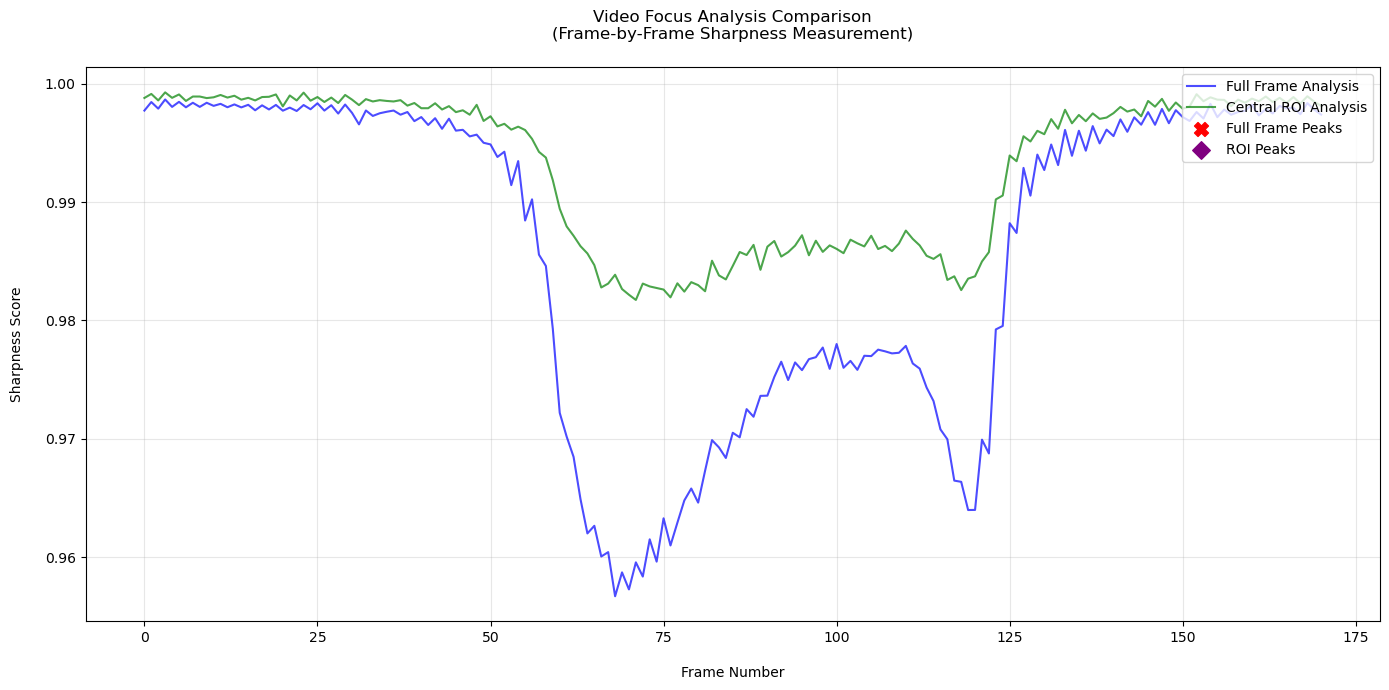

In [10]:
if __name__ == "__main__":
    # Process video frames
    full_scores = process_full_frame(output_dir, unsharp_masking = 1)
    roi_scores = process_central_roi(output_dir, unsharp_masking = 1)
    
    # Detect focus points
    full_peaks = detect_sharpness_peaks(full_scores)
    roi_peaks = detect_sharpness_peaks(roi_scores)
    
    # Generate visualization
    plot_sharpness_analysis(full_scores, roi_scores, full_peaks, roi_peaks)